In [2]:
import os
import os.path
import pandas as pd
import numpy as np
import datetime
import matplotlib
import pickle
import json
import googlemaps
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

%matplotlib inline

In [3]:
mapbox_access_token = open('../mapbox_token.txt', 'r').read()
matplotlib.rcParams['figure.figsize'] = (14.0, 7.0)

In [4]:
DATA_PATH = '/Users/ilaif/Desktop/data/avito'

In [5]:
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), parse_dates=['activation_date'])

In [6]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), parse_dates=['activation_date'])

Let's look at the raw columns we have in train.csv:

In [7]:
train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

## Feature enrichment

### Datetime

In [8]:
train['year'] = train['activation_date'].apply(lambda d: d.year)
train['month'] = train['activation_date'].apply(lambda d: d.month)
train['day'] = train['activation_date'].apply(lambda d: d.day)

test['year'] = test['activation_date'].apply(lambda d: d.year)
test['month'] = test['activation_date'].apply(lambda d: d.month)
test['day'] = test['activation_date'].apply(lambda d: d.day)

### Geocoding (adding lat, lng coordinates)

In [10]:
cities_geo = json.load(open(os.path.join('helper_data', 'cities_geo.json'), 'r'))
cities_geo_df = pd.DataFrame(cities_geo).transpose().reset_index()
cities_geo_df.columns = ['city', 'lat', 'lng']
train = train.merge(cities_geo_df, on='city')

### Translation

In [12]:
for col_name in ['parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3']:
    trans_dict = json.load(open(os.path.join('helper_data', col_name + '_en.json'), 'r'))
    train[col_name + '_en'] = train[col_name].apply(lambda t: trans_dict[t] if not pd.isnull(t) else t)

### Word Embedding

We turn to use word embeddings to represent the "params" description. We've downloaded a ready-to-use russian word embeddings from "Polyglot":
https://sites.google.com/site/rmyeid/projects/polyglot.
Let's load those:

In [14]:
with open(os.path.join('helper_data', 'polyglot-ru.pkl'), 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    words, embeddings = u.load()
print("Emebddings shape is {}".format(embeddings.shape))

Emebddings shape is (100004, 64)


Some othe Russian word2vec to explore later on:
https://github.com/nlpub/russe-evaluation/tree/master/russe/measures/word2vec

Let's see how many of the (meaningful) words from params appear in the wrodEmbeddings dictionary.
We first filter out Stopwords. We've examined 3 lists of stopwords:
* https://gist.github.com/menzenski/7047705
* https://www.ranks.nl/stopwords/russian
* https://www.symantec.com/connect/downloads/russian-stop-words-list

After consulting with our russian linguist, we've picked the third option because it had the least amount of words (the first two would filter out important semantic info).

In [15]:
stopwords = set()
import codecs
with codecs.open(os.path.join(DATA_PATH, 'helper_data', 'stopwords_ru.txt'), encoding='cp1251') as ins:
    for w in ins:
        word = w.strip("\r\n")
        word = word.strip("\n")
        stopwords.add(word)
        stopwords.add(word.upper())
        stopwords.add(word[0].upper() + word[1:])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ilaif/Desktop/data/avito/helper_data/stopwords_ru.txt'

Now we proceed to check how many meaningful words appear in "params".

In [16]:
# Returns true iff *any* word in sentense is present in words.
def param_meaningfull_word_ratio(row):
    sentence = ""
    for att in ["param_1","param_2","param_3"]:
        if not pd.isnull(row[att]):
            sentence += row[att]
        sentence += " "

    count = 0
    present = 0
    for w in sentence.split():
        count += 1
        if (w in words) and (w not in stopwords):
            present += 1
    return present / float(count)

# We sample 10,000 ads.
N = 10000
train_present_params = train[~(train["param_1"].isnull() & train["param_2"].isnull() & train["param_3"].isnull())].sample(N)
train_present_params['param_1_has_meaningful'] = train_present_params.apply(param_meaningfull_word_ratio, axis=1)
print("We sampled",N,"rows.")
num_meaningful = len(train_present_params[train_present_params['param_1_has_meaningful'] > 0.0])
print(num_meaningful,"Have meaningful words in their params (That's",num_meaningful/float(N)*100,"%).")

We sampled 10000 rows.
8226 Have meaningful words in their params (That's 82.26 %).


TODO: reduce meaningful words that are "close" to each other to representatives (k means?).

TODO: appen embeddings to train df.

TODO: append each embedded feature as a seperate col to train df.

### Text features

In [21]:
train["description_len"] = train['description'].apply(lambda s: len(s.split()) if type(s) == str else 0)

## Data Exploration

Let's see some data!

In [22]:
train.head(10)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,month,day,lat,lng,parent_category_name_en,category_name_en,param_1_en,param_2_en,param_3_en,description_len
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,3,28,56.8389,60.6057,Personal things,Goods for children and toys,Bed dress,NaN,NaN,7
1,838a82cec0a6,5d44315f6d90,Свердловская область,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,> 50 (XXL),Шапка норковая,...,3,16,56.8389,60.6057,Personal things,"Clothes, shoes, accessories",Women&#39;s clothing,Outerwear,&gt; 50 (XXL),17
2,161a8d6b87b5,43e3aa5b47ee,Свердловская область,Екатеринбург,Личные вещи,Часы и украшения,Ювелирные изделия,NaN,NaN,Золото 585(лом),...,3,27,56.8389,60.6057,Personal things,Watches &amp; Jewelry,Jewelry,NaN,NaN,4
3,601e7b35dfed,7ae3266c2538,Свердловская область,Екатеринбург,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,122-128 см (6-8 лет),Продам куртку Marc 'O Polo,...,3,21,56.8389,60.6057,Personal things,Children&#39;s clothing and footwear,For girls,Outerwear,122-128 cm (6-8 years),3
4,1ce37a04b861,16d27a450d50,Свердловская область,Екатеринбург,Для дома и дачи,Бытовая техника,Для дома,Стиральные машины,NaN,"Стиральная машина LG,5 кг., гарантия",...,3,17,56.8389,60.6057,For home and cottages,Appliances,For home,Washing machines,NaN,50
5,1759e0208e02,42679c942594,Свердловская область,Екатеринбург,Недвижимость,"Дома, дачи, коттеджи",Продам,Дача,NaN,Дача 20 м² на участке 10 сот.,...,3,18,56.8389,60.6057,The property,"Houses, cottages, cottages",Selling,Country house,NaN,70
6,db89df39cc0a,3c7f89780118,Свердловская область,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,NaN,NaN,Фурнитура,...,3,26,56.8389,60.6057,Personal things,"Clothes, shoes, accessories",Accessories,NaN,NaN,3
7,372778d7a7dd,b0b823fa1148,Свердловская область,Екатеринбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Брюки,Без размера,Новые леггинцы Livia Co Польша,...,3,18,56.8389,60.6057,Personal things,"Clothes, shoes, accessories",Women&#39;s clothing,Pants,Without size,6
8,a9944f63fa64,96a5497489a6,Свердловская область,Екатеринбург,Для дома и дачи,Ремонт и строительство,Потолки,NaN,NaN,Потолок подвесной armstrong accord 60x60,...,3,19,56.8389,60.6057,For home and cottages,Repair and construction,Ceilings,NaN,NaN,68
9,f503c2a82b0d,1ddc1058dd28,Свердловская область,Екатеринбург,Хобби и отдых,Билеты и путешествия,Путешествия,NaN,NaN,"Горящий Китай, о.Хайнань 9 ночей 4-5 звезд",...,3,17,56.8389,60.6057,Hobbies and Recreation,Tickets and travel,Travels,NaN,NaN,58


### Feature correlation

In [23]:
#TODO: Doesn't say anything

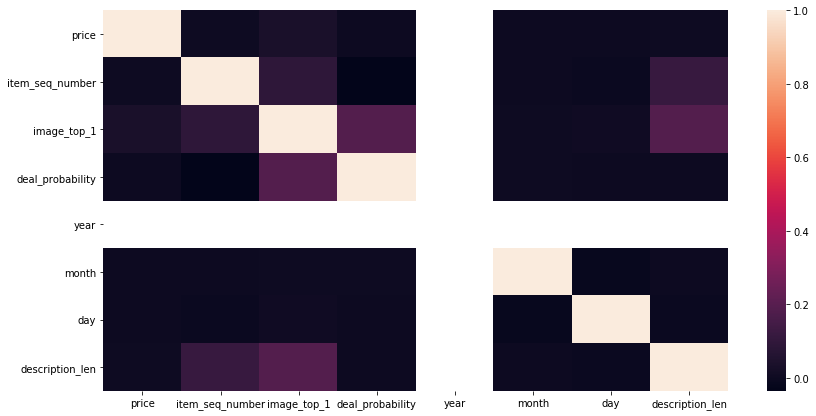

In [24]:
corr = train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

### Categories

How many unique categories and parent categories do we have?

In [25]:
print ("Num of parent categories: ",len(train["parent_category_name"].unique()))
print ("Num of categories: ",len(train["category_name"].unique()))

Num of parent categories:  9
Num of categories:  47


How many unique (distinct) "param"s we have?

In [26]:
print("Num of distinct params: "
      ,len(set(train["param_1"].tolist()) | set(train["param_2"].tolist()) | set(train["param_3"].tolist())))

Num of distinct params:  1841


Nice. We think that combining those with the "params" attributes can generate the most informative features about of the data. But in order to engeneer those, we need to "categorize" it somehow. Lets see how many ads do not have any param mentioned within it.

In [27]:
ads_with_absent_params = len(train[train["param_1"].isnull() & train["param_2"].isnull() & train["param_3"].isnull()])
total_ads = train.shape[0]
print ("Absent params:",ads_with_absent_params)
print ("Total ads:",total_ads)
print ("ration of ads with no params at all:",ads_with_absent_params / float(total_ads))

Absent params: 61576
Total ads: 1503424
ration of ads with no params at all: 0.0409571750883317


### What are the user types?

In [28]:
user_type_dist = train.groupby('user_type').size()

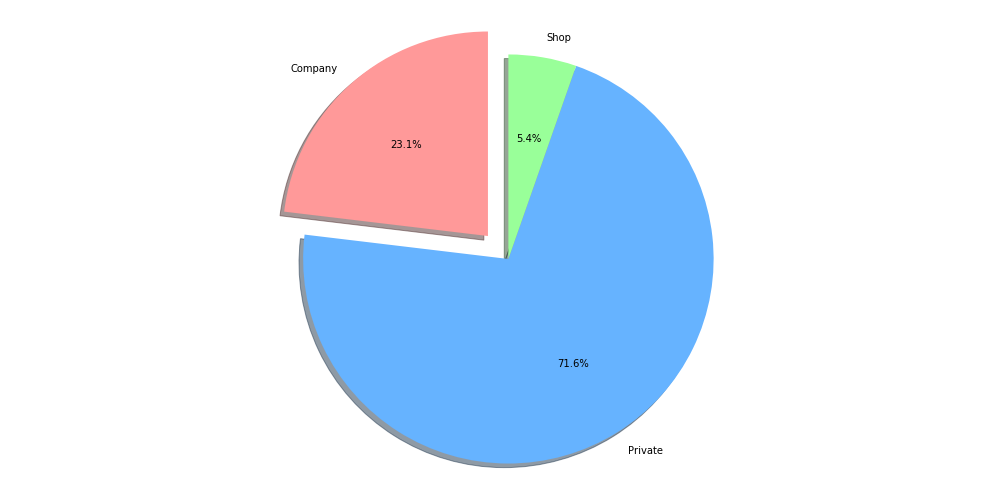

In [29]:
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [30]:
train[train['user_type'] == 'Company']['user_id'].nunique()

142941

In [31]:
train[train['user_type'] == 'Company']['user_id'].nunique()

142941

In [32]:
train[train['user_type'] == 'Company']['user_id'].nunique()

142941

In [33]:
company_users_frequency = train[train['user_type'] == 'Company'].groupby('user_id')['item_id'].nunique()

In [34]:
company_users_frequency.sort_values(ascending=False).head(10)

user_id
abcdd1ca1a5c    807
b5003ea27e7a    684
2cd9f03d6527    657
33d09dfdbd90    523
41f112adb74b    512
762434c0fd7e    382
743f3355d84a    370
c2920abccec4    363
9bdc2002bf51    360
1e19ac0f143f    354
Name: item_id, dtype: int64

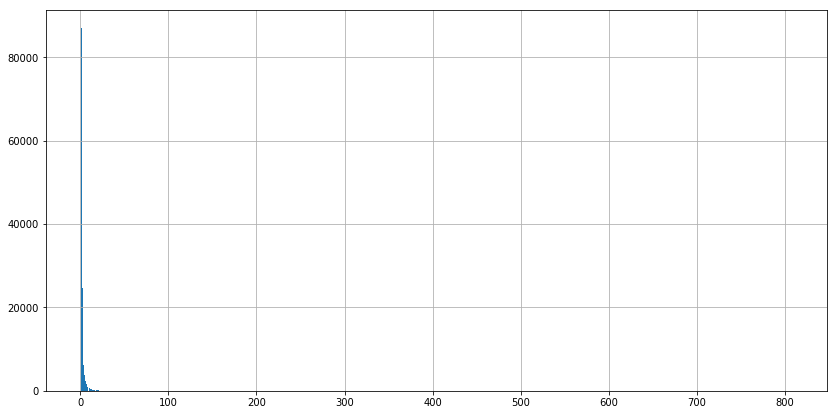

In [35]:
company_users_frequency.hist(bins=1000)

### How are the items distributed over cities?

In [36]:
site_lat = cities_geo_df.lat
site_lng = cities_geo_df.lng
locations_name = cities_geo_df.city

In [41]:
data = Data([
    Scattermapbox(
        lat=site_lat,
        lon=site_lng,
        mode='markers',
        marker=Marker(size=17, color='rgb(255, 0, 0)', opacity=0.7),
        text=locations_name,
        hoverinfo='text'
    ),
    Scattermapbox(
        lat=site_lat,
        lon=site_lng,
        mode='markers',
        marker=Marker(size=8, color='rgb(242, 177, 172)', opacity=0.7),
        hoverinfo='none'
    )]
)
        
layout = Layout(
    title='Cities that items are posted at',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(accesstoken=mapbox_access_token, bearing=0, center=dict(lat=53, lon=40), pitch=0, zoom=3, style='light'),
)

fig = dict(data=data, layout=layout)

py.iplot(fig)

### Distribution of items by category

<BarContainer object of 47 artists>

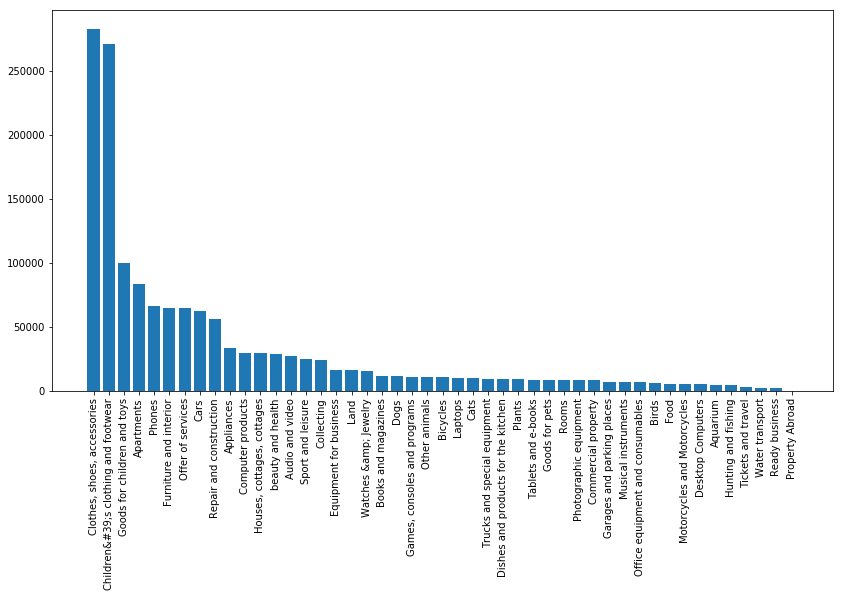

In [42]:
category_counts = train.groupby('category_name_en')['item_id'].count().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)

<BarContainer object of 9 artists>

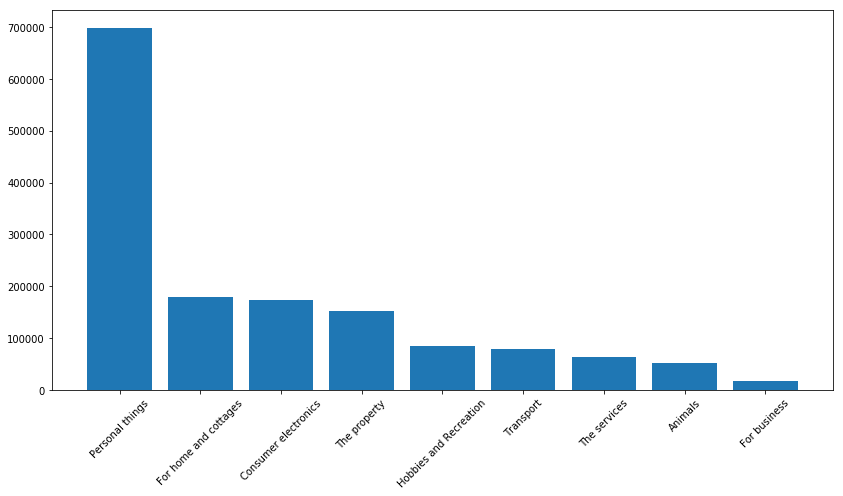

In [43]:
parent_category_counts = train.groupby('parent_category_name_en')['item_id'].count().sort_values(ascending=False)
plt.xticks(rotation=45)
plt.bar(parent_category_counts.index, parent_category_counts.values)

## Feature Engineering

We'll try to label categories and run some out of the box algorithms and see the result:

In [54]:
train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability', 'year',
       'month', 'day', 'lat', 'lng', 'parent_category_name_en',
       'category_name_en', 'param_1_en', 'param_2_en', 'param_3_en',
       'description_len'],
      dtype='object')

We will turn the predictions to 11 buckets:

In [55]:
def separate_to_bins(prob):
    return int(prob * 100 / 10)

In [64]:
train_num = 100000
features_data_df = train[['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'item_seq_number', 'month']]
y_df = train['deal_probability']
X = pd.DataFrame(features_data_df[:train_num]).fillna(0).values
y = pd.DataFrame(y_df[:train_num]).apply(separate_to_bins, axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = pd.DataFrame(X_train).values
X_test = pd.DataFrame(X_test).values
y_train = pd.DataFrame(y_train).values
y_test = pd.DataFrame(y_test).values

In [65]:
l = LogisticRegression()
r = RandomForestClassifier(n_estimators=25, max_depth=10)

les = []
for i in range(X.shape[1]):
    le = preprocessing.LabelEncoder()
    le.fit(X[:, i])
    les.append(le)
    X_train[:, i] = le.transform(X_train[:, i])
    X_test[:, i] = le.transform(X_test[:, i])

Naive random prediction:

In [66]:
y_pred = np.random.randint(1, size=y_test.shape[0])
accuracy_score(y_test, y_pred)

0.74028

In [67]:
l.fit(X_train, np.ravel(y_train))
y_pred = l.predict_proba(X_test)
#print(log_loss(y_test,y_pred, labels=range(10)))

In [68]:
accuracy_score(y_test, l.predict(X_test))

0.74028

In [69]:
r.fit(X_train, np.ravel(y_train))
y_pred = r.predict_proba(X_test)
#print(log_loss(y_test, y_pred, labels=range(10)))

In [70]:
accuracy_score(y_test, r.predict(X_test))

0.73952

#TODO:

In [63]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train)
X_train_one_hot = enc.transform(X_train)
X_test_one_hot = enc.transform(X_train)
l.fit(X_train_one_hot, y_train)
y_pred = l.predict_proba(X_test_one_hot)
print(log_loss(y_test, y_pred))
r.fit(X_train_one_hot, y_train)
y_pred = r.predict_proba(X_test_one_hot)
print(log_loss(y_test, y_pred))
print(X_train_one_hot.shape)

/Users/ilaif/.virtualenvs/ds/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ValueError: Found input variables with inconsistent numbers of samples: [7500, 2500]